In [2]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import pickle

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate
from scipy.integrate import ode, solve_ivp, odeint

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

sys.path.append('../')
import bubbles

In [3]:
%load_ext autoreload
%autoreload 2

# Optically thin region

How big is proximity zone around galaxies? What is required ionizing flux to observe blue Lya?

In [4]:
def R_optically_thin(z, Ndot_ion, alpha_s, reccase='B', 
                     T=1e4*u.K, fesc=0.1, C=3, tau_lim=2.3, J_bg=0):
    """
    Proper radius of Lya optically thin region
    
    aka proximity zone
    """
    
    A = 1.34e-7 * u.cm**3. / u.s
    sigma_ion0 = 6.3e-18 * u.cm**2
    
    if reccase == 'B':
        alpha_rec = bubbles.alpha_rec_B(T.value)
    else:
        alpha_rec = bubbles.alpha_rec_A(T.value)

    gamma_lim = A * C**2. * bubbles.n_H(z)**2. * alpha_rec / Planck15.H(z) / tau_lim
    
    R_alpha2 = fesc/4./np.pi * sigma_ion0 * Ndot_ion * (alpha_s/(alpha_s - 3)) / (gamma_lim - J_bg*bubbles.Gamma12(z)/u.s)
    return np.sqrt(R_alpha2).to(u.Mpc)

def blue_velocity_lim(R_alpha, z):
    vlim = R_alpha * Planck15.H(z) #/(1+z)
    return vlim.to(u.km/u.s)

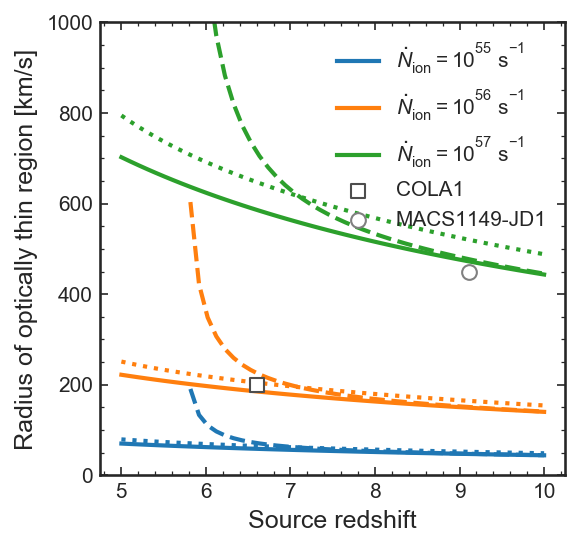

In [25]:
ztab = np.linspace(5., 10)
Ndot_ion_tab = np.logspace(55, 57, 3)/u.s

observations = {}
observations['COLA1'] = {'z':6.6, 'vlim':200, 'M1500':-21.6, 'c':'0.3', 'ms':'s'}
observations['MACS1149-JD1'] = {'z':9.11, 'vlim':450, 'M1500':-18.5, 'c':'0.5', 'ms':'o'}

for ob in observations:
    plt.scatter(observations[ob]['z'], observations[ob]['vlim'], 
                lw=1, edgecolors=observations[ob]['c'], facecolor='w', 
                s=50, marker=observations[ob]['ms'], 
                zorder=100, label=ob)
#     plt.annotate(ob, xy=(observations[ob]['z']-0.1, observations[ob]['vlim']), 
#                  xycoords='data', ha='right', va='center')

for Ndot_ion in Ndot_ion_tab:
    R_alpha = R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-1.8, fesc=1)    
    vlim    = blue_velocity_lim(R_alpha, ztab)    
    ln = plt.plot(ztab, vlim, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))

    R_alpha = R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-1.8, fesc=1, J_bg=50)    
    vlim    = blue_velocity_lim(R_alpha, ztab)   
    plt.plot(ztab, vlim, c=ln[0].get_color(), ls='dashed')

    R_alpha = R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-2.5, fesc=1, J_bg=1)    
    vlim    = blue_velocity_lim(R_alpha, ztab)   
    plt.plot(ztab, vlim, c=ln[0].get_color(), ls='dotted')

plt.legend()

plt.ylim(0., 1000)
plt.xlabel('Source redshift')
plt.ylabel('Radius of optically thin region [km/s]')

plt.savefig('../figs/Ralpha_z.pdf', bbox_inches='tight')

## As a function of Ndot_ion

To compare with Bolton & Haehnelt (2007) ~ 2-5 pMpc for Ndot_ion ~ 1-7e57 s^-1

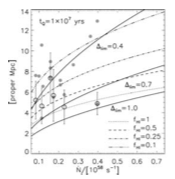

Text(0, 0.5, 'Radius of optically thin region [pMpc]')

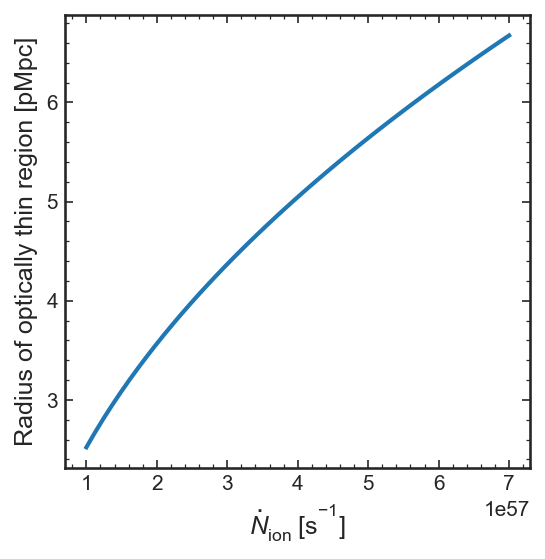

In [6]:
ztest = 6
Ndot_ion_tab = np.linspace(0.1,0.7)*1e58/u.s

R_alpha = R_optically_thin(z=ztest, Ndot_ion=Ndot_ion_tab, 
                           reccase='A', alpha_s=-1.5, fesc=1, C=1, T=2e4*u.K)    
    
plt.plot(Ndot_ion_tab, R_alpha)

plt.xlabel('$\dot{N}_\mathrm{ion} \; [$s$^{-1}]$')
plt.ylabel('Radius of optically thin region [pMpc]')

## As a function of UV magnitude

In [7]:
def Muv_to_Lnu(Muv, z, beta=-2.):
    
    lum_dist = Planck15.luminosity_distance(z)
    mab = Muv + 5.0 * (np.log10(lum_dist.to(u.pc).value) - 1.0) - (2.5 * np.log10(1.0 + z))
    
    f0  = 3.631E-20*u.erg/u.s/u.Hz/u.cm**2.
    c   = 3.E5*u.km/u.s
    wave912 = 912.*u.Angstrom
    
    fnu_912 = f0 * 10**(-0.4*mab) * (1500*u.Angstrom/wave912)**(beta-2.)
    Lnu_912 = fnu_912 * 4*np.pi * lum_dist**2.
    
    return Lnu_912.to(u.erg/u.s/u.Hz)

def Muv_to_Nion(Muv, z, alpha_s=-1.8, beta=-2):
    
    Lnu_912 = Muv_to_Lnu(Muv, z, beta=beta)
    
    Nion = Lnu_912/const.h/-alpha_s

    return Nion.to(1/u.s)

Muv_to_Nion(-24, z=8, alpha_s=-2)

<Quantity 1.60512187e+56 1 / s>

0.0
0.6666666666666667


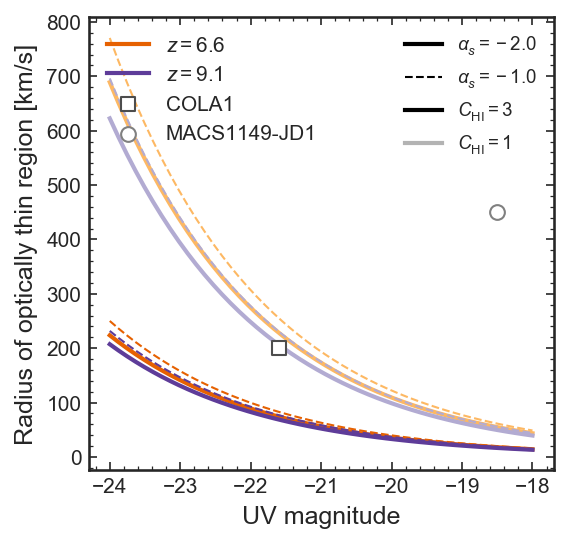

In [79]:
from palettable.colorbrewer.diverging import PuOr_4
col = PuOr_4.hex_colors # o_d, o_l, p_l, p_d


ztest = [6.6, 9.11]#7., 8.]
alpha_s_test = [-2, -1]
C_test = [3, 1]
Muv_tab = np.linspace(-24, -18)

ls = ['solid', 'dashed', 'dotted']
lw = [2, 1, 1]

for ob in observations:
    plt.scatter(observations[ob]['M1500'], observations[ob]['vlim'],
                lw=1, edgecolors=observations[ob]['c'], facecolor='w', 
                s=50, marker=observations[ob]['ms'], 
                zorder=100, label=ob)
    
for zz, z in enumerate(ztest):

    for i, alpha_s in enumerate(alpha_s_test):

        Ndot_ion_tab = Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s, beta=-2)

        for cc, C in enumerate(C_test):
            R_alpha = R_optically_thin(z=z, Ndot_ion=Ndot_ion_tab, 
                                   reccase='B', alpha_s=alpha_s, 
                                   fesc=1, C=C, T=1e4*u.K, J_bg=1)        
            vlim = blue_velocity_lim(R_alpha, z)   

            # Only make label for C=3 and alpha = -2
            if i == 0 and cc == 0:
                label = '$z=%.1f$' % z
            else:
                label = None
            
            if zz == 0:
                c = col[zz+cc]
                # z=6.6 orange, dark for C = 1 (0)
#                 print(zz+cc)
            else:
                c = col[zz+1+np.abs(cc - 1)]
                # z=9.1 purple, dark for C = 1 (3)
#                 print(zz+1+np.abs(cc - 1))
            plt.plot(Muv_tab, vlim, c=c, ls=ls[i], lw=lw[i], label=label)
        
handles = []
for i, alpha_s in enumerate(alpha_s_test):
    ln = mlines.Line2D([], [], color='k', lw=lw[i], ls=ls[i], label=r'$\alpha_s = %.1f$' % alpha_s)
    handles.append(ln)
for i, C in enumerate(C_test):
    print(1-C/3.)
    ln = mlines.Line2D([], [], color='%.1f' % (1-C/3.), label=r'$C_\mathrm{HI} = %.0f$' % C)
    handles.append(ln)
    
leg = plt.legend(handles=handles, loc='upper right', fontsize=9)
plt.gca().add_artist(leg)

plt.legend(loc='upper left')

plt.xlabel('UV magnitude')
plt.ylabel('Radius of optically thin region [km/s]')

plt.savefig('../figs/Ralpha_Muv.pdf', bbox_inches='tight')

# How much does xHI need to change by to drop Lya fraction by 1/2

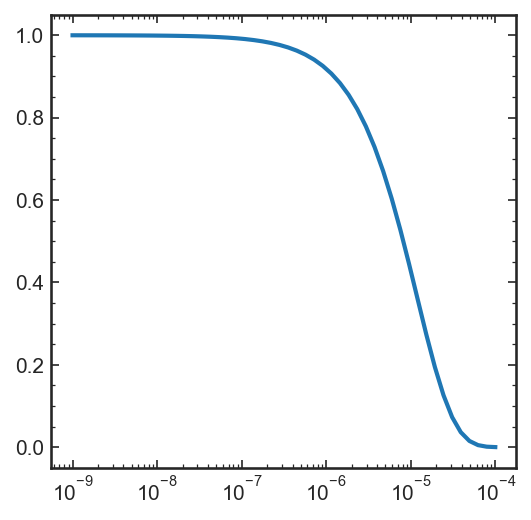

In [19]:
def tau_GP(z, xHI, C=1):
    tau = 1.34e-7*u.cm**3/u.s * C * xHI * bubbles.n_H(z)/Planck15.H(z)
    return tau.to(u.cm/u.cm)

ztab = np.linspace(5,10)
xtab = np.logspace(-9, -4)
plt.semilogx(xtab, np.exp(-(tau_GP(7, xHI=xtab) - tau_GP(6, xHI=xtab))))

In [39]:
def z_at_R(zs, r_p):
    return zs - r_p * Planck15.H(zs) * (1+zs)/const.c

z_at_R(7., r_p=1.*u.Mpc)

<Quantity 6.97719355>

<Quantity 6.97719355>